In [1]:
# CHANGE THIS IF YOU NOT ON COLAB
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
!pip install numpy
!pip install torch
!pip install torchvision
!pip install jupyter
!pip install matplotlib
!pip install pandas
!pip install scikit-learn

In [3]:
import pylab
import numpy as np
import pandas as pd
import math

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms, models, ops
from torchvision.models.resnet import ResNet, BasicBlock

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import scipy
import matplotlib.pyplot as plt
from PIL import Image
import os
import shutil
import time
from tempfile import TemporaryDirectory

In [4]:
data_dir = './'
drive_dir = './drive/MyDrive/SC4001'
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# CHANGE THIS IF YOU NOT ON COLAB
print(f"Downloading Training dataset:")
train_dataset = datasets.Flowers102(root=os.path.join(data_dir, "train"), split='train', transform=data_transforms['train'], download=True)
# train_dataset = datasets.Flowers102(root=os.path.join(drive_dir, "train"), split='train', transform=data_transforms['train'], download=True)

print(f"Downloading Validation dataset:")
val_dataset = datasets.Flowers102(root=os.path.join(data_dir, "train"), split='val', transform=data_transforms['val'])
# val_dataset = datasets.Flowers102(root=os.path.join(drive_dir, "train"), split='val', transform=data_transforms['val'])

print(f"Downloading Test dataset:")
test_dataset = datasets.Flowers102(root=os.path.join(data_dir, "train"), split='test', transform=data_transforms['test'])
# test_dataset = datasets.Flowers102(root=os.path.join(drive_dir, "train"), split='test', transform=data_transforms['test'])

In [5]:
batch_size = 4
datasets = {
    'train': train_dataset,
    'val': val_dataset,
    'test': test_dataset
}

# print(f"{len(train_dataset._labels)}")
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val', 'test']}
# class_names = image_datasets['train'].classes

print(f"dataloaders: {dataloaders}")
print(f"Dataset sizes: {dataset_sizes}")


dataloaders: {'train': <torch.utils.data.dataloader.DataLoader object at 0x2aab9894ff70>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x2aab9894fe80>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x2aab988bd390>}
Dataset sizes: {'train': 1020, 'val': 1020, 'test': 6149}


In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # CHANGE THIS IF YOU NOT ON COLAB
    checkpoint_path = './model_checkpoints'
#     checkpoint_path = './drive/MyDrive/SC4001/model_checkpoints'
    train_loss, train_acc = [], []
    val_loss, val_acc = [], []
    # Create a temporary directory to save training checkpoints
    # with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(checkpoint_path, 't_deformed_aft_conv_resnet18.pt')

    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss:\t{epoch_loss:.4f}\tAcc:\t{epoch_acc:.4f}')

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            elif phase == 'val':
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, train_loss, train_acc, val_loss, val_acc

In [7]:
def calc_dim(layer, kernel_size, stride, padding):
    # print(f"Spatial Dimension: {math.floor(((layer - kernel_size + 2*(padding)) / stride) + 1)}")
    return math.floor(((layer - kernel_size + 2*(padding)) / stride) + 1)

def calc_depth(depth, name, tracking):
    curr_layer = name.split('.')[0]
    # print(f"{name} = {tracking}")
    if curr_layer == tracking:
        return depth, True, curr_layer
    else:
        return depth * 2, False, curr_layer

class deformed_CNN(ResNet):
    def __init__(self, batch_size, device):
        super(deformed_CNN, self).__init__(BasicBlock, [2, 2, 2, 2])
        self.offsets = {}
        self.weights = {}
        self.batch_size = batch_size
        # input image size before conv1 layer
        self.dim = 224
        # input image depth after conv1 layer
        self.channel = 64
        current_layer = "layer1"
        self.device = device
        for name, mod in self.named_modules():
            if "conv" in name and "layer" not in name:
                # print(f"name: {name}")
                self.dim = calc_dim(
                    self.dim,
                    self.get_submodule(f"{name}").kernel_size[0],
                    self.get_submodule(f"{name}").stride[0],
                    self.get_submodule(f"{name}").padding[0]
                )
                self.offsets[name] = torch.rand(
                    self.batch_size,
                    2 * 1 * self.get_submodule(f"{name}").kernel_size[0] * self.get_submodule(f"{name}").kernel_size[0],
                    self.dim,
                    self.dim
                ).to(self.device)
                self.weights[name] = torch.rand(
                    self.channel,
                    self.channel,
                    self.get_submodule(f"{name}").kernel_size[0],
                    self.get_submodule(f"{name}").kernel_size[0]
                ).to(self.device)
            elif "maxpool" in name:
                # print(f"name: {name}")
                self.dim = calc_dim(
                    self.dim,
                    self.get_submodule(f"{name}").kernel_size,
                    self.get_submodule(f"{name}").stride,
                    self.get_submodule(f"{name}").padding
                )
            elif "layer" in name and "conv" in name:
                # print(f"name: {name}")
                self.dim = calc_dim(
                    self.dim,
                    self.get_submodule(f"{name}").kernel_size[0],
                    self.get_submodule(f"{name}").stride[0],
                    self.get_submodule(f"{name}").padding[0]
                )
                if ".1.conv2" in name:
                    self.offsets[name] = torch.rand(
                        self.batch_size,
                        2 * 1 * self.get_submodule(f"{name}").kernel_size[0] * self.get_submodule(f"{name}").kernel_size[0],
                        self.dim,
                        self.dim
                    ).to(self.device)
                    new_channel, truth, current_layer = calc_depth(self.channel, name, current_layer)
                    # print(f"{name}\tFeature map depth: {new_channel}")
                    if not truth:
                        self.channel = new_channel
                    self.weights[name] = torch.rand(
                        self.channel,
                        self.channel,
                        self.get_submodule(f"{name}").kernel_size[0],
                        self.get_submodule(f"{name}").kernel_size[0]
                    ).to(self.device)

    def forward(self, x):
        # print(f"{self.conv1(x).detach().numpy()[0].shape}")
        if len(x) != self.batch_size:
            print(f"LAST LAYER: {len(x)}")
            self.offsets['conv1'] = torch.rand(
                len(x),
                2 * 1 * self.get_submodule(f"conv1").kernel_size[0] * self.get_submodule(f"conv1").kernel_size[0],
                112,
                112
            ).to(self.device)

            self.offsets['layer1.1.conv2'] = torch.rand(
                len(x),
                2 * 1 * self.get_submodule(f"conv1").kernel_size[0] * self.get_submodule(f"conv1").kernel_size[0],
                56,
                56
            ).to(self.device)

            self.offsets['layer2.1.conv2'] = torch.rand(
                len(x),
                2 * 1 * self.get_submodule(f"conv1").kernel_size[0] * self.get_submodule(f"conv1").kernel_size[0],
                28,
                28
            ).to(self.device)

            self.offsets['layer3.1.conv2'] = torch.rand(
                len(x),
                2 * 1 * self.get_submodule(f"conv1").kernel_size[0] * self.get_submodule(f"conv1").kernel_size[0],
                14,
                14
            ).to(self.device)

            self.offsets['layer4.1.conv2'] = torch.rand(
                len(x),
                2 * 1 * self.get_submodule(f"conv1").kernel_size[0] * self.get_submodule(f"conv1").kernel_size[0],
                7,
                7
            ).to(self.device)

        relu = nn.ReLU()
        out = self.conv1(x)
        # print(f"shape: {self.conv1(x).detach().numpy().shape}")
        out = ops.deform_conv2d(
            out,
            self.offsets['conv1'],
            self.weights['conv1'],
            stride=1,
            padding=self.conv1.padding[0]
        )
        out = self.bn1(out)
        out = relu(out)
        out = self.maxpool(out)
        out = self.layer1(out)
        # out = ops.deform_conv2d(
        #     out,
        #     self.offsets['layer1.1.conv2'],
        #     self.weights['layer1.1.conv2'],
        #     stride=1,
        #     padding=self.layer1[1].conv2.padding[0]
        # )

        out = self.layer2(out)
        # out = ops.deform_conv2d(
        #     out,
        #     self.offsets['layer2.1.conv2'],
        #     self.weights['layer2.1.conv2'],
        #     stride=1,
        #     padding=self.layer2[1].conv2.padding[0]
        # )

        out = self.layer3(out)
        # out = ops.deform_conv2d(
        #     out,
        #     self.offsets['layer3.1.conv2'],
        #     self.weights['layer3.1.conv2'],
        #     stride=1,
        #     padding=self.layer3[1].conv2.padding[0]
        # )

        out = self.layer4(out)
        # out = ops.deform_conv2d(
        #     out,
        #     self.offsets['layer4.1.conv2'],
        #     self.weights['layer4.1.conv2'],
        #     stride=1,
        #     padding=self.layer4[1].conv2.padding[0]
        # )

        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)

        return out

In [8]:
# !nvcc --version

In [9]:
# CHANGE THIS IF YOU NOT ON COLAB
# deformed_model_path = './drive/MyDrive/SC4001/model_checkpoints/deformed_resnet18.pt'
deformed_model_path = './model_checkpoints/deformed_aft_conv_resnet18.pt'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

check_file = os.path.exists(deformed_model_path)
if check_file:
    # Loading my saved deformed model weights into model
    print(f"Loading model from checkpoint")
    model = deformed_CNN(batch_size, device)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 102)
    temp = torch.load(deformed_model_path)
    model.load_state_dict(temp.state_dict())
#     model.load_state_dict(torch.load(deformed_model_path))
else:
    # Saving resnet original weights
    print(f"Model checkpoint does not exist.\nDownloading new model...")
    model_resnet = models.resnet18(weights='IMAGENET1K_V1')
    checkpoint_path = 'model_checkpoints'
    # CHANGE THIS IF NOT USING GOOGLE DRIVE
    og_resnet_path = os.path.join(data_dir, checkpoint_path, 'og_resnet.pt')
#     og_resnet_path = os.path.join(drive_dir, checkpoint_path, 'og_resnet.pt')
    torch.save(model_resnet.state_dict(), og_resnet_path)

    # Loading resnet original weights into my deformed model
    model = deformed_CNN(batch_size, device)
    model.load_state_dict(torch.load(og_resnet_path))

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 102)


model = model.to(device)
model.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 50 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=50, gamma=0.1)

Device: cuda:0
Model checkpoint does not exist.


In [10]:
no_epochs = 40

model, train_loss, train_acc, val_loss, val_acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=no_epochs)
# for inputs, labels in dataloaders['train']:
#     print(f"inputs:\t{len(inputs)}")
#     outputs = model(inputs)
#     print(f"outputs: {outputs.detach().numpy().shape}")
#     break

Epoch 0/39
----------
train Loss:	4.8749	Acc:	0.0147
val Loss:	4.6201	Acc:	0.0333

Training complete in 0m 25s
Best val Acc: 0.033333
Epoch 1/39
----------
train Loss:	4.6772	Acc:	0.0225
val Loss:	4.3851	Acc:	0.0833

Training complete in 0m 46s
Best val Acc: 0.083333
Epoch 2/39
----------
train Loss:	4.4881	Acc:	0.0471
val Loss:	4.2532	Acc:	0.0912

Training complete in 1m 7s
Best val Acc: 0.091176
Epoch 3/39
----------
train Loss:	4.3060	Acc:	0.0569
val Loss:	4.0010	Acc:	0.1294

Training complete in 1m 28s
Best val Acc: 0.129412
Epoch 4/39
----------
train Loss:	4.1234	Acc:	0.0902
val Loss:	3.8565	Acc:	0.1373

Training complete in 1m 50s
Best val Acc: 0.137255
Epoch 5/39
----------
train Loss:	3.9772	Acc:	0.1088
val Loss:	3.6832	Acc:	0.1775

Training complete in 2m 11s
Best val Acc: 0.177451
Epoch 6/39
----------
train Loss:	3.7652	Acc:	0.1461
val Loss:	3.4979	Acc:	0.2059

Training complete in 2m 32s
Best val Acc: 0.205882
Epoch 7/39
----------
train Loss:	3.5970	Acc:	0.1676
val Loss:	

In [11]:
torch.save(model, deformed_model_path)

In [12]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

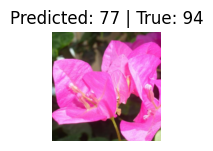

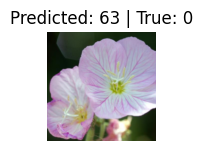

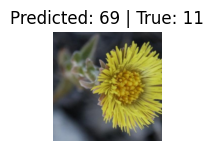

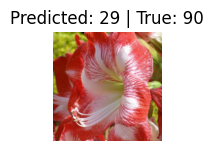

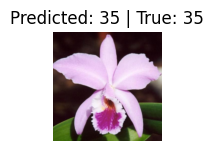

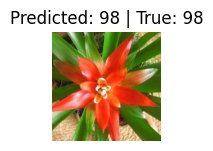

In [13]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                # Changed classes to labels so it corresponds to the labels from dataloader['val']
                ax.set_title(f'Predicted: {preds[j]} | True: {labels[j]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model)

In [14]:
def plot_graph(no_epoch, train, val, title):
    plt.figure()
    plt.plot(range(no_epoch), train, label='train')
    plt.plot(range(no_epoch), val, label='val')
    if "Accuracy" in title:
        plt.ylabel("Accuracy")
    elif "Loss" in title:
        plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()

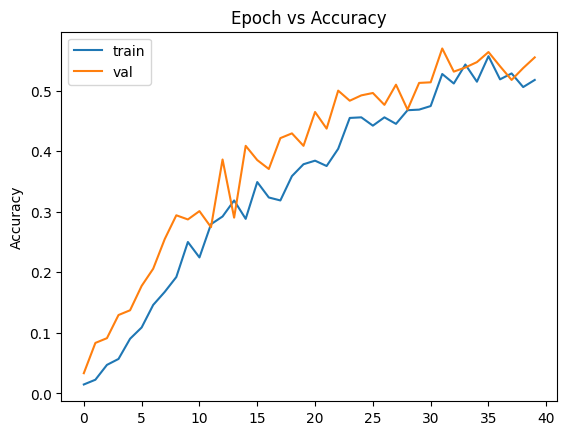

In [15]:
for i in range(len(train_acc)):
    train_acc[i] = train_acc[i].cpu()
    val_acc[i] = val_acc[i].cpu()

plot_graph(no_epochs, train_acc, val_acc, "Epoch vs Accuracy")

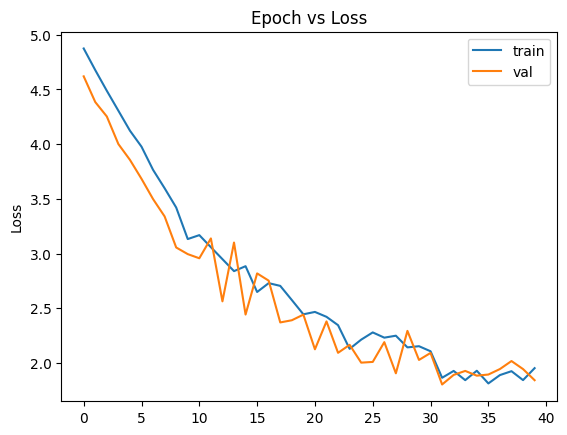

In [16]:
plot_graph(no_epochs, train_loss, val_loss, "Epoch vs Loss")

In [17]:
def test(model):
    was_training = model.training
    model.eval()
    # fig = plt.figure()
    size = len(dataloaders['test'].dataset)
    no_batches = len(dataloaders['test'])
    test_loss, correct = 0, 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            test_loss += criterion(outputs, labels).item() * inputs.size(0)
            correct += torch.sum(preds == labels.data)
            if i % 50 == 0:
                print(f'Predicted: {preds[0]} | True: {labels[0]}')
            # for j in range(inputs.size()[0]):
            #     images_so_far += 1
                # ax = plt.subplot(num_images//2, 2, images_so_far)
                # ax.axis('off')
                # Changed classes to labels so it corresponds to the labels from dataloader['val']
                # ax.set_title(f'Predicted: {preds[j]} | True: {labels[j]}')
                # imshow(inputs.cpu().data[j])

                # if images_so_far == num_images:
                    # model.train(mode=was_training)
                    # return
    test_loss /= size
    correct = correct.double() / size
    model.train(mode=was_training)
    return test_loss, correct

In [18]:
test_loss, test_acc = test(model)

Predicted: 93 | True: 3
Predicted: 42 | True: 42
Predicted: 86 | True: 87
Predicted: 10 | True: 45
Predicted: 51 | True: 80
Predicted: 50 | True: 50
Predicted: 77 | True: 77
Predicted: 38 | True: 38
Predicted: 25 | True: 25
Predicted: 57 | True: 57
Predicted: 78 | True: 78
Predicted: 90 | True: 90
Predicted: 76 | True: 76
Predicted: 27 | True: 91
Predicted: 71 | True: 71
Predicted: 53 | True: 53
Predicted: 25 | True: 25
Predicted: 53 | True: 53
Predicted: 29 | True: 2
Predicted: 56 | True: 76
Predicted: 69 | True: 69
Predicted: 75 | True: 82
Predicted: 98 | True: 98
Predicted: 75 | True: 75
Predicted: 19 | True: 19
Predicted: 24 | True: 93
Predicted: 45 | True: 45
Predicted: 46 | True: 11
Predicted: 45 | True: 101
Predicted: 57 | True: 57
Predicted: 94 | True: 42
LAST LAYER: 1


In [19]:
print(f'Test Loss:\t{test_loss:.4f}\tTest Acc:\t{test_acc:.4f}')

Test Loss:	2.1045	Test Acc:	0.5076


In [20]:
print(f"{model}")

deformed_CNN(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tr